In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/DeepLearning_Summer2022/Final_Project'

Mounted at /content/drive


In [2]:
# Load our cleaned ClinVar data from the EVE paper
df_cv = pd.read_csv(dir_path+'/Data/precursor_files/EVE_ClinVar_cleaned_annotated_GRCh38.csv')
df_cv['uniprot'] = [x.split('UniProtKB:')[-1].split('#')[0] for x in df_cv['OtherIDs']]

# Load our sequence file with canonical human sequences
df_up = pd.read_csv(dir_path+'/Data/precursor_files/uniprot_canonical_human_proteins.tsv',sep='\t')

# Merge sequence information with ClinVar annotations
df = df_cv.merge(df_up,left_on='uniprot',right_on='Entry',how='left').dropna()

# Format mutations from clinvar data
df['mutant_pos'] = [int(x[1:-1]) for x in df['mutant']]
df['mutant_wt'] = [x[0] for x in df['mutant']]
df['mutant_mut'] = [x[-1] for x in df['mutant']]

results = []

# Make sure your clinvar annotation WT amino acid matches that of the recovered
# sequence (baseline QC)
for i in range(len(df)):
    try:
        x = df.iloc[i]['Sequence'][df.iloc[i]['mutant_pos']-1]
        if x == df.iloc[i]['mutant_wt']:
            results.append(True)
        else:
            results.append(False)
    except:
        print('mismatch at {}, {} {}'.format(i,df.iloc[i]['Entry'],df.iloc[i]['mutant']))
        results.append(False)
        
df['WT_match'] = results
df = df.query('WT_match == True')
print('Remaining entries: {} entries covering {} proteins'.format(len(df),len(set(df['uniprot']))))

mismatch at 1568, O75923 R2081C
mismatch at 5488, P02708 C463W
mismatch at 7184, Q8WZ42 V34563A
mismatch at 7188, Q8WZ42 K35209Q
mismatch at 7195, Q9Y6N9 E819D
mismatch at 7647, Q719H9 A638E
mismatch at 7648, Q719H9 P639R
mismatch at 7649, Q719H9 P639L
mismatch at 7650, Q719H9 H641Q
mismatch at 7651, Q719H9 H641P
mismatch at 7652, Q719H9 H682P
mismatch at 7653, Q719H9 G670D
mismatch at 9527, O76039 V999M
mismatch at 9575, P20929 I8437V
mismatch at 10713, P20929 D6731V
mismatch at 10714, P20929 T7867I
mismatch at 10790, Q7LG56 M354I
mismatch at 10791, Q7LG56 L389V
mismatch at 11329, P04049 T661M
mismatch at 11388, P51608 P492S
mismatch at 12511, Q8WZ42 T35028M
mismatch at 12710, Q13976 G681A
mismatch at 14145, Q9BYJ1 P762L
Remaining entries: 14235 entries covering 1548 proteins


In [3]:
# Generate fasta file with sequences for the 1548 proteins in the ClinVar full 
# set
z = set(df['Sequence'])
with open(dir_path+'/Data/precursor_files/ClinVar_Seqs.fa','w') as f:
    for seq in z:
        f.write('>{}\n'.format(df.query('Sequence == @seq').iloc[0]['uniprot']))
        f.write(seq+'\n')


Mean seq length: 1122.374148226203
Median seq length: 686.0


Text(0, 0.5, 'Counts')

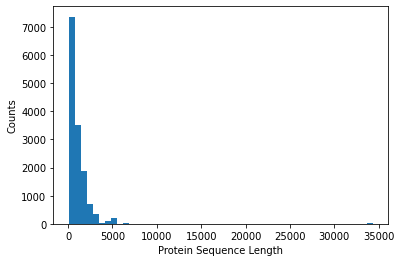

In [4]:
# Let's see what the distribution of sequence lengths looks like
print('Mean seq length: {}'.format(np.mean(df['Length'])))
print('Median seq length: {}'.format(np.median(df['Length'])))
plt.hist(df['Length'],bins=50)
plt.xlabel('Protein Sequence Length')
plt.ylabel('Counts')

In [5]:
# Let's get some numbers associated with these
print('Number of entries with seq lengths < 3000: {}'.format(len(df.query('Length < 3000'))))
print('Length < 3000 and Pathogenic: {}'.format(len(df.query('Length < 3000 and Starry_Coarse_Grained_Clin_Sig=="pathogenic"'))))
print('Length < 3000 and Benign: {}'.format(len(df.query('Length < 3000 and Starry_Coarse_Grained_Clin_Sig=="benign"'))))
print('Length < 3000 and Uncertain: {}'.format(len(df.query('Length < 3000 and Starry_Coarse_Grained_Clin_Sig=="uncertain"'))))
print('Fraction of definite labels with pathogenic: {}'.format(3662/(3662+2086)))

Number of entries with seq lengths < 3000: 13665
Length < 3000 and Pathogenic: 3662
Length < 3000 and Benign: 2086
Length < 3000 and Uncertain: 7917
Fraction of definite labels with pathogenic: 0.6370911621433543


In [6]:
## Now, let's identify which clusters (15% identity) these sequences all belong
## to
prots = []
clusters = []
current_cluster = 0
with open(dir_path + '/Data/precursor_files/CD-HIT/1658330861.result/1658330861.fas.1.clstr.sorted','r') as f:

  for line in f:
    if line.startswith('>'):
      current_cluster = int(line.split('Cluster ')[1][:-1])
    else:
      prots.append(line.split('>')[1].split('...')[0])
      clusters.append(current_cluster)

df_clusters = pd.DataFrame({'Entry':prots,'Cluster':clusters})
df = df.merge(df_clusters,on='Entry',how='left').sort_values(by='Cluster',ascending=True)

In [7]:
df.to_csv(dir_path+'/Data/processed_clinvar_seqs_with_clusters.csv')

# Generate test-train-validate splits

In [16]:
def get_pathogenic_split_and_length_stats(df_var,which_type='train'):
  print('Total length {}: {}, {} pathogenic, {} benign'.format(
      which_type,
      len(df_var),len(df_var.query('Starry_Coarse_Grained_Clin_Sig == "pathogenic"')),
      len(df_var.query('Starry_Coarse_Grained_Clin_Sig == "benign"'))))
  
  print('Pathogenic percent: {0:.2f}'.format(
      len(df_var.query('Starry_Coarse_Grained_Clin_Sig == "pathogenic"'))/(len(df_var.query('Starry_Coarse_Grained_Clin_Sig == "pathogenic"'))+len(df_var.query('Starry_Coarse_Grained_Clin_Sig == "benign"')))
      ))
  
  x1 = df_var.query('(Starry_Coarse_Grained_Clin_Sig=="benign") or (Starry_Coarse_Grained_Clin_Sig=="pathogenic")')
  print('Mean sequence length benign or pathogenic in {}: {}'.format(which_type,np.mean(x1['Length'])))
  print('Median sequence length benign or pathogenic in {}: {}'.format(which_type,np.median(x1['Length'])))
  print('Number of unique Uniprot IDs: {}'.format(len(set(x1['uniprot']))))
  print('\n')


## Generate test-train splits by shuffling clusters of sequences, while ensuring there is no overlap of sequence clusters between train-validate-split

In [17]:
df = pd.read_csv(dir_path+'/Data/processed_clinvar_seqs_with_clusters.csv')

# Randomly shuffle the clusters so that we won't have as big a length dependence
groups = [df_cluster for cluster_id, df_cluster in df.groupby('Cluster')]
random.shuffle(groups) 
df_shuffle = pd.concat(groups).reset_index(drop=True)

# Let's find markers for our train/test split
intersect80 = df_shuffle.iloc[int(len(df_shuffle)*0.8)]['Cluster']
intersect90 = df_shuffle.iloc[int(len(df_shuffle)*0.9)]['Cluster']
print('Cluster where our 80% mark intersects: {}'.format(intersect80))
print('Cluster where our 90% mark intersects: {}'.format(intersect90))

# Get our cutoff values for our split, making sure that we don't divide a 
# cluster over different splits
cutoff_80 = max(df_shuffle.query('Cluster == @intersect80').index)
cutoff_90 = max(df_shuffle.query('Cluster == @intersect90').index)

# Get our train/validate/test splits
df_train = df_shuffle.iloc[:cutoff_80+1]
df_validate = df_shuffle.iloc[cutoff_80+1:cutoff_90+1]
df_test= df_shuffle.iloc[cutoff_90+1:]

# Get our statistics
get_pathogenic_split_and_length_stats(df_train,'train')
get_pathogenic_split_and_length_stats(df_validate,'validate')
get_pathogenic_split_and_length_stats(df_test,'test')

# Finally, write the output
df_train.to_csv(dir_path+'/Data/train_processed_clinvar_seqs_with_clusters_clustershuffle.csv')
df_validate.to_csv(dir_path+'/Data/validate_processed_clinvar_seqs_with_clusters_clustershuffle.csv')
df_test.to_csv(dir_path+'/Data/test_processed_clinvar_seqs_with_clusters_clustershuffle.csv')


Cluster where our 80% mark intersects: 237
Cluster where our 90% mark intersects: 844
Total length train: 11415, 3076 pathogenic, 1930 benign
Pathogenic percent: 0.61
Mean sequence length benign or pathogenic in train: 1245.8953256092689
Median sequence length benign or pathogenic in train: 755.0
Number of unique Uniprot IDs: 852


Total length validate: 1399, 268 pathogenic, 128 benign
Pathogenic percent: 0.68
Mean sequence length benign or pathogenic in validate: 1206.4419191919192
Median sequence length benign or pathogenic in validate: 862.0
Number of unique Uniprot IDs: 64


Total length test: 1421, 391 pathogenic, 255 benign
Pathogenic percent: 0.61
Mean sequence length benign or pathogenic in test: 1178.4318885448915
Median sequence length benign or pathogenic in test: 860.0
Number of unique Uniprot IDs: 128




## Generate test-train split with no consideration of sequences (purely random shuffling of variants (rows), this can lead to the same or similar sequences being in the train-validate-test sets)

In [18]:
df = pd.read_csv(dir_path+'/Data/processed_clinvar_seqs_with_clusters.csv')

# Shuffle rows
df_shuffle_all = df.sample(frac=1).reset_index(drop=True)

# Get our cutoffs for split
intersect80 = int(0.8*len(df))
intersect90 = int(0.9*len(df))
df_train = df_shuffle_all.iloc[:intersect80]
df_validate = df_shuffle_all.iloc[intersect80:intersect90]
df_test = df_shuffle_all.iloc[intersect90:]

# Get our statistics
get_pathogenic_split_and_length_stats(df_train,'train')
get_pathogenic_split_and_length_stats(df_validate,'validate')
get_pathogenic_split_and_length_stats(df_test,'test')

# Write output
df_train.to_csv(dir_path+'/Data/train_processed_clinvar_seqs_random.csv')
df_validate.to_csv(dir_path+'/Data/validate_processed_clinvar_seqs_random.csv')
df_test.to_csv(dir_path+'/Data/test_processed_clinvar_seqs_random.csv')

Total length train: 11388, 3007 pathogenic, 1833 benign
Pathogenic percent: 0.62
Mean sequence length benign or pathogenic in train: 1259.6547520661156
Median sequence length benign or pathogenic in train: 756.0
Number of unique Uniprot IDs: 960


Total length validate: 1423, 379 pathogenic, 240 benign
Pathogenic percent: 0.61
Mean sequence length benign or pathogenic in validate: 1165.2714054927303
Median sequence length benign or pathogenic in validate: 773.0
Number of unique Uniprot IDs: 339


Total length test: 1424, 349 pathogenic, 240 benign
Pathogenic percent: 0.59
Mean sequence length benign or pathogenic in test: 1117.0424448217318
Median sequence length benign or pathogenic in test: 750.0
Number of unique Uniprot IDs: 343


